In [1]:
import trimesh
def pytorch3d_to_trimesh(p3d_mesh):
    # Get vertices and faces from the PyTorch3D mesh
    vertices = p3d_mesh.verts_packed().detach().cpu().numpy()
    faces = p3d_mesh.faces_packed().detach().cpu().numpy()

    # Create a Trimesh object
    return trimesh.Trimesh(vertices=vertices, faces=faces)

In [29]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Dummy source class to mock required methods
class DummySource:
    def __init__(self, num_verts_per_mesh, faces_packed, faces_packed_to_mesh_idx):
        self._num_verts_per_mesh = num_verts_per_mesh
        self._faces_packed = faces_packed
        self._faces_packed_to_mesh_idx = faces_packed_to_mesh_idx

    def num_verts_per_mesh(self):
        return self._num_verts_per_mesh

    def faces_packed(self):
        return self._faces_packed

    def faces_packed_to_mesh_idx(self):
        return self._faces_packed_to_mesh_idx

    def num_faces_per_mesh(self):
        return torch.tensor([len(self._faces_packed) // len(self._num_verts_per_mesh)] * len(self._num_verts_per_mesh))

    def mesh_to_faces_packed_first_idx(self):
        return torch.cumsum(torch.tensor([0] + self.num_faces_per_mesh().tolist()[:-1]), dim=0)

# Define batch size and varying number of vertices per mesh
num_verts_per_mesh = torch.tensor([8, 4])  # Mesh 1 has 5 verts, Mesh 2 has 3 verts

verts = torch.tensor([
    [-0.5, -0.5, -0.5],  # 0
    [ 0.5, -0.5, -0.5],  # 1
    [ 0.5,  0.5, -0.5],  # 2
    [-0.5,  0.5, -0.5],  # 3
    [-0.5, -0.5,  0.5],  # 4
    [ 0.5, -0.5,  0.5],  # 5
    [ 0.5,  0.5,  0.5],  # 6
    [-0.5,  0.5,  0.5]   # 7
], dtype=torch.float32)
faces = torch.tensor([
    [0, 2, 1], [0, 3, 2],  # Front
    [1, 6, 5], [1, 2, 6],  # Right
    [5, 7, 4], [5, 6, 7],  # Back
    [4, 3, 0], [4, 7, 3],  # Left
    [3, 6, 2], [3, 7, 6],  # Top
    [4, 1, 5], [4, 0, 1]   # Bottom
], dtype=torch.int64)

verts2 = torch.tensor([
    [0,0,1],
    [1,0,0],
    [0,1,0], 
    [0,0,0]], dtype=torch.float32)
faces2 = torch.tensor([
    [3, 1, 2],
    [3, 1, 0],
    [3, 0, 2],
    [0, 1, 2]
], dtype=torch.int64)

# Pad sequences to match the batch shape (B, max Vi, 3)
y = pad_sequence([verts, verts2], batch_first=True)
# Define face indices assuming the first mesh has faces [(0,1,2), (1,2,3)] and second has [(0,1,2)]
faces_packed = torch.cat([faces, faces2])

# Face-to-mesh mapping (0 for first mesh, 1 for second)
faces_packed_to_mesh_idx = torch.tensor([0] * 12 + [1] * 4)

# Create a dummy source object
dummy_src = DummySource(num_verts_per_mesh, faces_packed, faces_packed_to_mesh_idx)

# Define a dummy class with the method
class DummyClass:
    def __init__(self, src):
        self.src = src

    def equality_constraints(self, xs, y, scatter_add=True):
        # Original function here
        n_batches = len(self.src.num_verts_per_mesh())

        lengths = self.src.num_verts_per_mesh()
        sorted_lengths, sort_indices = torch.sort(lengths, descending=True)
        y_sorted = y[sort_indices]  # Reorder y to match sorted order
        y_packed_seq = torch.nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_lengths, batch_first=True)

        # Later, unsort if necessary
        verts_packed = y_packed_seq.data

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)

        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.dtype)
        
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)

# Instantiate and test
dummy_instance = DummyClass(dummy_src)
xs_placeholder = torch.zeros_like(y)  # Placeholder tensor

volumes = dummy_instance.equality_constraints(xs_placeholder, y)
print("Computed volumes:", volumes)


Computed volumes: tensor([0.0833, 0.0833])


In [ ]:
def equality_constraints(self, xs: torch.Tensor, y: torch.Tensor):
    """
    Enforces volume constraint
    Assumes same number of vertices in each projected mesh currently

    Args:
        xs (tensor): vertices of original mesh, B x V x 3
        y (tensor): vertices of projected mesh, B x V x 3
    """
    n_batches = len(xs)
    verts = y.view(n_batches,-1,3) # (B, V, 3)

    faces = self.src.faces_padded().view(n_batches, -1, 3).detach()  # (B, max F_i, 3)
    _, n_faces, _ = faces.size()
    batch_indices = torch.arange(n_batches)[:, None, None].expand(-1, n_faces, 3).detach() # detached

    face_vertices = verts[batch_indices, faces]  # (B, F, 3, 3)
    # Calculate volume
    v0, v1, v2 = face_vertices[:, :, 0, :], face_vertices[:, :, 1, :], face_vertices[:, :, 2, :]
    cross = torch.cross(v1, v2, dim=-1)  # (B, F, 3)
    face_volumes = torch.einsum('bfi,bfi->bf', v0, cross) / 6.0  # (B, F)

    volumes = torch.sum(face_volumes, dim=1).abs() # (B,)
    return volumes  # (B,)


In [ ]:
def get_signed_tet_volume(face_vertices: torch.Tensor) -> torch.Tensor:
    """
    Compute signed tetrahedron volumes for a batch of faces.

    Args:
        face_vertices (torch.Tensor): Tensor of shape (F, 3, 3), where
                                      F is the number of faces, and each face
                                      consists of 3 vertices in 3D.

    Returns:
        torch.Tensor: A tensor of shape (F,) containing signed volumes.
    """
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)

    return volumes

def get_volume_batch(meshes: Meshes):
    verts_packed = meshes.verts_packed()  # (sum(V_i), 3)
    faces_packed = meshes.faces_packed()  # (sum(F_i), 3)
    mesh_to_face = meshes.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
    n_meshes = len(meshes)
    volumes = torch.zeros(n_meshes, device=verts_packed.device)

    for i in range(n_meshes):
        start = mesh_to_face[i]
        end = start + meshes.num_faces_per_mesh()[i]
        face_vertices = verts_packed[faces_packed[start:end]]  # (F, 3, 3)
        volumes[i] = get_signed_tet_volume(face_vertices).sum()  # Sum over all faces

    return volumes.abs()  # Returns a tensor of shape (num_meshes,)

def least_squares(u0, target):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(target):
        target = torch.tensor(target)

    res = torch.square(u0 - target).sum()
    print("lstsq", res)
    return res.double()

def least_squares_grad(u0, target):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
        
    if torch.is_tensor(target):
        target = target.detach().clone()
    else:
        target = torch.tensor(target)
        
    # Ensure that u0 requires gradients
    u0.requires_grad = True
    
    with torch.enable_grad():
        res = torch.square(u0 - target).sum()

    # Compute the gradient
    obj_grad = torch.autograd.grad(res, u0)[0]
    print("obj_grad", obj_grad)
    return obj_grad.double()

def get_volume(u, faces, init_vol):
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(init_vol):
        init_vol = torch.tensor(init_vol)
    
    vertices = u.view(-1,3)
    face_vertices = vertices[faces]  # (F, 3, 3)
    volume = get_signed_tet_volume(face_vertices).sum()
    res = volume.abs() - init_vol
    print("vol", res)
    return res.double()

def get_volume_grad(u, faces, init_vol):
    if not torch.is_tensor(u):
        u = torch.tensor(u, dtype=torch.float64, requires_grad=True)
    else:
        u = u.clone().detach().requires_grad_(True)
    
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces, dtype=torch.long)
    
    if not torch.is_tensor(init_vol):
        init_vol = torch.tensor(init_vol, dtype=torch.float64)
    
    with torch.enable_grad():
        vertices = u.view(-1, 3)
        face_vertices = vertices[faces]  # (F, 3, 3)
        volume = get_signed_tet_volume(face_vertices).sum()
        res = volume.abs() - init_vol
    
    volume_grad = torch.autograd.grad(res, u, retain_graph=True)[0]
    print("volume grad", volume_grad)
    
    return volume_grad.double()

def project(meshes: Meshes, targets: Meshes):
    n_batches = len(meshes)
    n_vtxs = len(meshes[0].verts_packed())
    results = torch.zeros(n_batches, n_vtxs, 3, dtype=torch.double)
    losses = torch.zeros(n_batches, 1, dtype=torch.double)
    for batch_number, mesh in enumerate(meshes):
        init_vol = get_volume_batch(mesh).double().detach().cpu().numpy()
        print("batch number", batch_number)
        vertices = mesh.verts_packed().flatten().detach().numpy().astype(np.float64)
        faces = mesh.faces_packed().detach().numpy().astype(np.int64)
        target_vtx = targets[batch_number].verts_packed().flatten().detach().numpy().astype(np.float64)
        eq_const = {
            'type': 'eq',
            'fun' : lambda u: get_volume(u, faces, init_vol).cpu().numpy().astype(np.float64),
            'jac' : lambda u: get_volume_grad(u, faces, init_vol).cpu().numpy().astype(np.float64)
        }
        print("starting optimisation")
        res = opt.minimize(
            lambda u: least_squares(u, target_vtx).detach().cpu().numpy().astype(np.float64),
            vertices, 
            jac=lambda u: least_squares_grad(u, target_vtx).cpu().numpy().astype(np.float64),
            method='SLSQP', 
            constraints=[eq_const],
            options={'ftol': 1e-4, 'disp': True, 'maxiter': 100}
        )   
        print("finished")
        if not res.success:
            print("FIT failed:", res.message)
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        losses[batch_number] = torch.tensor(res.fun, dtype=torch.double, requires_grad=False)
    return results, losses


In [2]:
import torch
from pytorch3d.loss import chamfer_distance

In [3]:
batch_size = 2
num_points = 25
dim = 2

# Generate two random batches of point clouds
x = torch.rand((batch_size,num_points, dim))  # (N, P1, D)
y = torch.rand((batch_size,num_points, dim))  # (N, P2, D)

print(x.dtype, y.dtype)

# Compute Chamfer distance
loss, _ = chamfer_distance(x, y)
print("Chamfer Distance:", loss.item())

torch.float32 torch.float32
Chamfer Distance: 0.028457235544919968


In [2]:
import numpy as np
from numpy import sqrt
# P = np.array([[1,0,0,0],
#               [0,1,0,0],
#               [0,0,0,1]])

P = np.array([[-1/sqrt(2),1/sqrt(2),0,0],
              [-1/sqrt(6),-1/sqrt(6),2/sqrt(6),0],
              [0,0,0,1]])

# P = np.array([[-1/sqrt(5),2/sqrt(5),0,0],
#               [-2/sqrt(30),-1/sqrt(30),5/sqrt(30),0],
#               [0,0,0,1]])


Q = 1/3 * np.array([[4,2, 0, 0],
                    [2,4,0,0],
                    [0,0,3,0],
                    [0,0,0,-3]])
# Cstar = P @ np.linalg.inv(Q) @ P.T
Cstar = P @ Q @ P.T
print(Cstar)
print(np.linalg.inv(Cstar))

[[ 6.66666667e-01  5.39323902e-18  0.00000000e+00]
 [ 1.65108562e-17  1.33333333e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
[[ 1.50000000e+00 -6.06739390e-18  0.00000000e+00]
 [-1.85747132e-17  7.50000000e-01  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.00000000e+00]]


In [3]:
import torch
a = torch.randn(3, 3)
a = a @ a.mT + 1e-3 # make symmetric positive-definite
l = torch.cholesky(a)
print(a)
print(l @ l.mT)
print(l.mT @ l)
# a = torch.randn(3, 2, 2) # Example for batched input
# a = a @ a.mT + 1e-03 # make symmetric positive-definite
# l = torch.cholesky(a)
# z = l @ l.mT
# torch.dist(z, a)

tensor([[1.1117, 1.2023, 1.0289],
        [1.2023, 5.9874, 0.6625],
        [1.0289, 0.6625, 1.0273]])
tensor([[1.1117, 1.2023, 1.0289],
        [1.2023, 5.9874, 0.6625],
        [1.0289, 0.6625, 1.0273]])
tensor([[ 3.3644,  2.2658,  0.1740],
        [ 2.2658,  4.7303, -0.0371],
        [ 0.1740, -0.0371,  0.0318]])


/var/folders/5f/p7wxm9ss4y79jh19st9d10h80000gn/T/ipykernel_22037/1183037652.py:4: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1699.)
  l = torch.cholesky(a)


In [6]:
print(np.pi * sqrt(- np.linalg.det(Cstar)))

3.5124073655203634


In [7]:
np.pi * sqrt(3/2) * sqrt(5/6)

3.512407365520363

In [35]:
import torch

In [47]:
R =np.array([[0.5, 0, sqrt(3)/2],
              [0, 1, 0],
              [-sqrt(3)/2, 0 , 0.5]])  @ np.array([[-1, 0, 0],
              [0, -1, 0],
              [0, 0 , 1]])
A = np.array([[1, 0, -0.5],
              [0, 1, 0],
              [-0.5, 0, 1]])

M  = R @ A @ R.T
print(M)
def schur_complement_batch(M):
    A, B, C, D, E, F = M[:,0,0], M[:, 1,1], M[:, 2,2], M[:, 0,1], M[:, 0,2], M[:, 1,2]
    return np.stack([np.stack([A - E**2/C, D - E*F/C]),
                        np.stack([D - E*F/C, B - F**2/C])])

schur_complement_batch(M[np.newaxis,:])

[[ 1.4330127  0.        -0.25     ]
 [ 0.         1.         0.       ]
 [-0.25       0.         0.5669873]]


array([[[1.32278096],
        [0.        ]],

       [[0.        ],
        [1.        ]]])

In [44]:
R @ np.array([0,0,1])

array([0.8660254, 0.       , 0.5      ])

In [49]:
A =    np.array([[1,0,-1/2,0],
                [0,1,0,0],
                [-1/2, 0, 1,0],
                [0,0,0,1]])
P = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,0,1]])

R =np.array([[0.5, 0, sqrt(3)/2],
              [0, 1, 0],
              [-sqrt(3)/2, 0 , 0.5]])  @ np.array([[-1, 0, 0],
              [0, -1, 0],
              [0, 0 , 1]])
A = np.array([[1, 0, -0.5],
              [0, 1, 0],
              [-0.5, 0, 1]])

M  = R @ A @ R.T

P = np.array([[-0.5,0,sqrt(3)/2,0],
              [0,1,0,0],
              [0,0,0,1]])
def make_homogeneous(mat3x3):
    """Convert a 3x3 matrix to a 4x4 homogeneous matrix."""
    mat4x4 = np.eye(4)  # Start with an identity matrix
    mat4x4[:3, :3] = mat3x3  # Insert the 3x3 matrix
    return mat4x4

P @ np.linalg.inv(make_homogeneous(M)) @ P.T

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ]])

In [1]:
import torch
import numpy as np
import os
import re
from collections import defaultdict
import cv2
from cv2.typing import MatLike

def load_camera_matrices(path, matrix_types=None):
    """
    Loads camera matrices from .npy files in the specified directory.

    Parameters:
        path (str): Path to the directory containing camera matrix files.
        matrix_types (set or list, optional): Specifies which matrix types to load (e.g., {'K', 'RT'}).
        If None, all available matrices ('K', 'RT', 'P') will be loaded.

    Returns:
        dict: A dictionary mapping camera numbers to their respective matrices.
    """
    cameras = defaultdict(dict)
    file_pattern = re.compile(r"^Camera_(\d+)_(K|RT|P)\.npy$")
    
    if matrix_types is not None:
        matrix_types = set(matrix_types)  # Ensure it's a set for quick lookup
    
    for filename in sorted(os.listdir(path)):  # Sort filenames alphabetically
        match = file_pattern.match(filename)
        if match:
            cam_number, matrix_type = match.groups()
            cam_number = int(cam_number)  # Convert camera number to integer
            if matrix_types is None or matrix_type in matrix_types:
                filepath = os.path.join(path, filename)
                cameras[cam_number][matrix_type] = torch.tensor(np.load(filepath))
    
    return cameras

def load_renders(renders_path):
    renders = defaultdict(dict)
    pattern = re.compile(r"([a-zA-Z]+)(\d+)\.png")
    for filename in sorted(os.listdir(renders_path), key=lambda x: (re.match(pattern, x).group(1), int(re.match(pattern, x).group(2))) if re.match(pattern, x) else (x, float('inf'))):
        match = pattern.match(filename)
        if match:
            word, number = match.groups()
            number = int(number)  # Convert number to integer for sorting

            image_path = os.path.join(renders_path, filename)
            image = cv2.imread(image_path)  # Load image using OpenCV
            if image is not None:
                renders[word][number] = image  # Store image in the nested dictionary

    return renders

def get_projmats_and_edgemap_info(view_idx, target_mesh: str, matrices, edgemaps, edgemaps_len):
    """
    Retrieves the projection matrices and target edgemap information for the specified view indices and target mesh.

    Parameters:
        view_idx (list): List of indices for which to retrieve projection matrices and edgemaps.
        target_mesh (str): The target mesh name (e.g., 'balloon') to extract edgemaps and lengths for.
        matrices (dict): Dictionary containing camera matrices.
        edgemaps (dict): Dictionary containing edgemaps for various meshes.
        edgemaps_len (dict): Dictionary containing the lengths of the edgemaps for each mesh.

    Returns:
        tuple: A tuple containing the projection matrices (torch.Tensor) and the target edgemap information (tuple of torch.Tensors).
    """
    # Get the projection matrices for the specified view indices
    projmats = torch.stack([matrices[view_idx[i]]["P"] for i in range(len(view_idx))])

    # Get the target edgemaps for the specified target mesh
    tgt_edgemaps = torch.nn.utils.rnn.pad_sequence([edgemaps[target_mesh][i] for i in view_idx], batch_first=True, padding_value=0.0)
    tgt_edgemaps_len = torch.tensor([edgemaps_len[target_mesh][i] for i in view_idx])

    # Pack the target edgemaps and their lengths
    tgt_edgemap_info = (tgt_edgemaps, tgt_edgemaps_len)

    return projmats, tgt_edgemap_info

def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    # edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map

def load_edgemaps(renders, options):
    edgemaps = {}
    edgemaps_len = {}

    # Iterate through the renders dictionary, which is grouped by mesh names
    for mesh_name, mesh_renders in renders.items():
        views = {}
        views_len = {}
        
        # Find the edgemap options for the current mesh name
        if mesh_name in options:
            edgemap_options = options[mesh_name]

            # Iterate through each render (view) for the current mesh
            for num, img in mesh_renders.items():
                # Apply the corresponding edgemap options for this render number (num)
                if num in edgemap_options:
                    edge_option = edgemap_options[num]
                    edges = canny_edge_map(img, edge_option)
                    edge_coords = np.argwhere(edges > 0)
                    edge_coords = edge_coords[:, [1, 0]]  # Convert to (x, y) coordinates
                    
                    views[num] = torch.tensor(edge_coords)
                    views_len[num] = len(edge_coords)

        # Store the results for the current mesh
        edgemaps[mesh_name] = views
        edgemaps_len[mesh_name] = views_len

    return edgemaps, edgemaps_len


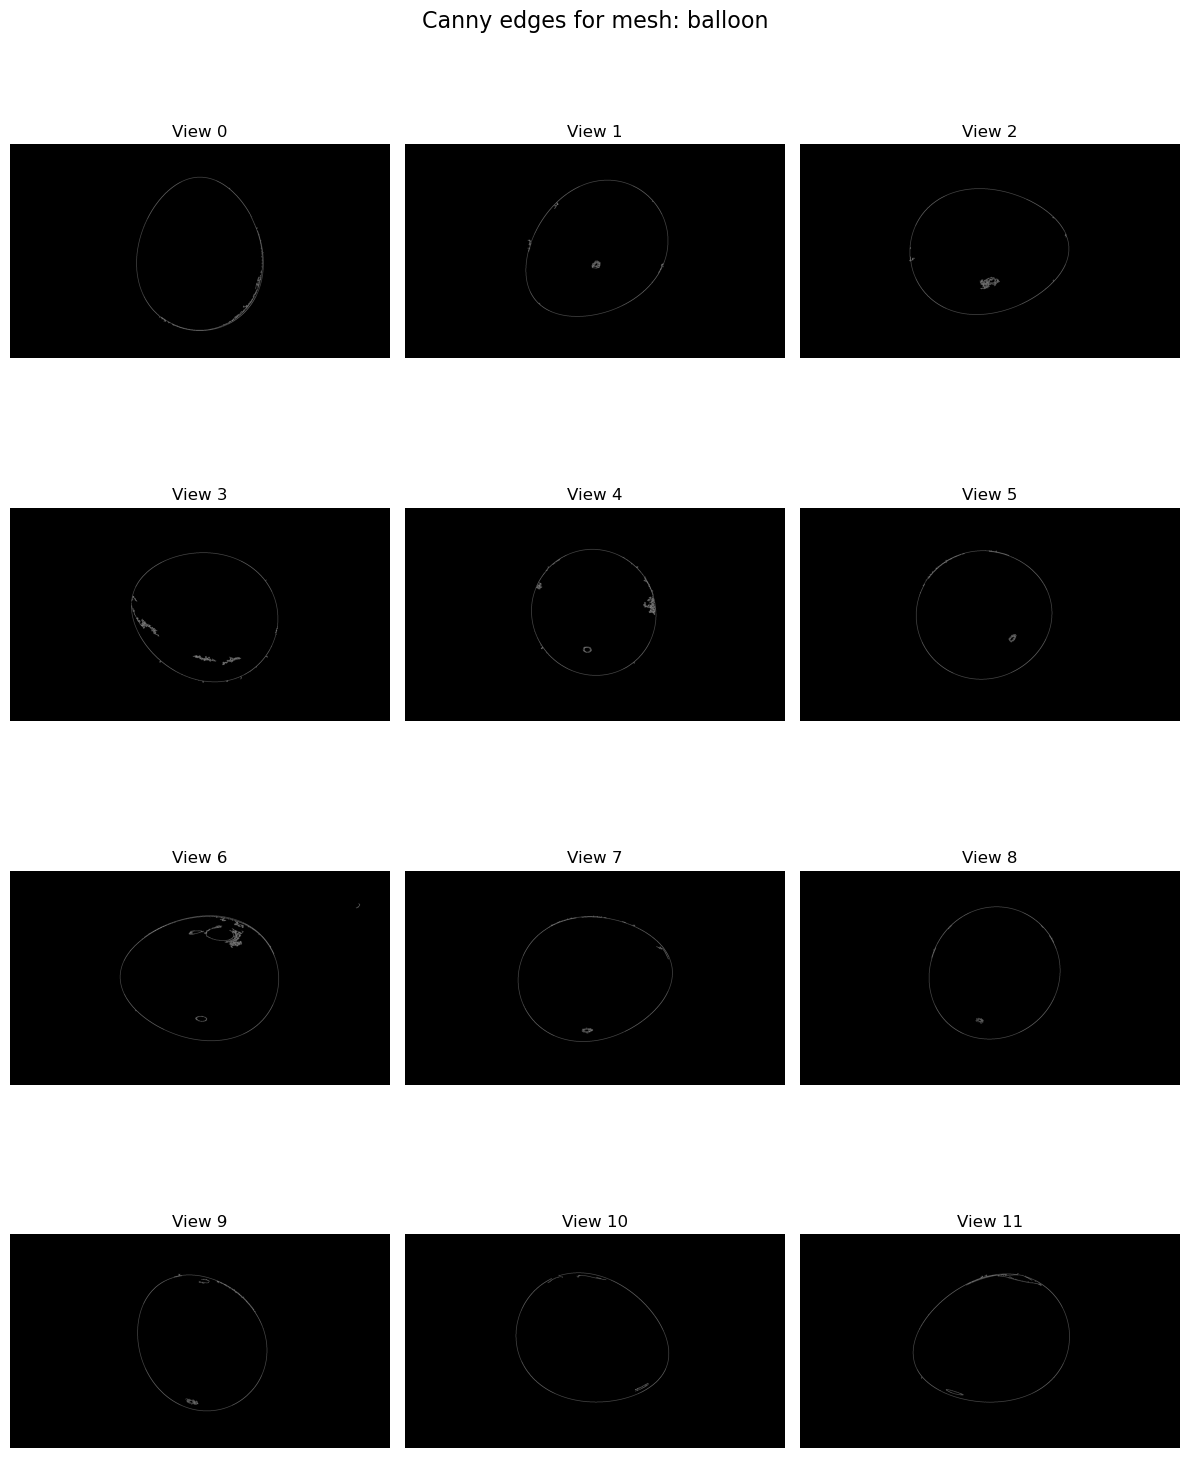

In [89]:
import json
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
def canny_edge_map(img, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map


def visualize_edges(renders, edgemap_options, target_mesh):
    num_views = 12  # assuming 12 views per mesh
    rows, cols = 4,3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    mesh_renders = renders.get(target_mesh, {})
    mesh_options = edgemap_options.get(target_mesh, {})

    for view_idx in range(num_views):
        row, col = divmod(view_idx, cols)
        ax = axes[row, col]

        img = mesh_renders.get(view_idx)
        if img is not None and str(view_idx) in mesh_options:
            edge_option = mesh_options[str(view_idx)]
            edges = canny_edge_map(img, edge_option)
            ax.imshow(edges, cmap='gray')
        else:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)

        ax.set_title(f"View {view_idx}")
        ax.axis('off')

    plt.suptitle(f"Canny edges for mesh: {target_mesh}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Load configuration from JSON file
with open("/home/jeffrey/honours/src/experiments/skyconfig_edge1.json", "r") as f:
    cfg = json.load(f)

mesh_dir = cfg["paths"]["mesh_dir"]
mesh_res = cfg["paths"]["mesh_res"]
renders_path = cfg["paths"]["renders_path"]
matrices_path = cfg["paths"]["matrices_path"]

# Fix edgemap_options to be a dictionary where keys are mesh names and values are dictionaries of view indices
edgemap_options = {mesh["name"]: {str(k): v for k, v in mesh["edgemap_options"].items()} for mesh in cfg["meshes"]}

# Load renders and camera matrices
renders = load_renders(renders_path)
matrices = load_camera_matrices(matrices_path)

# Visualize edge maps
visualize_edges(renders, edgemap_options, target_mesh="balloon")


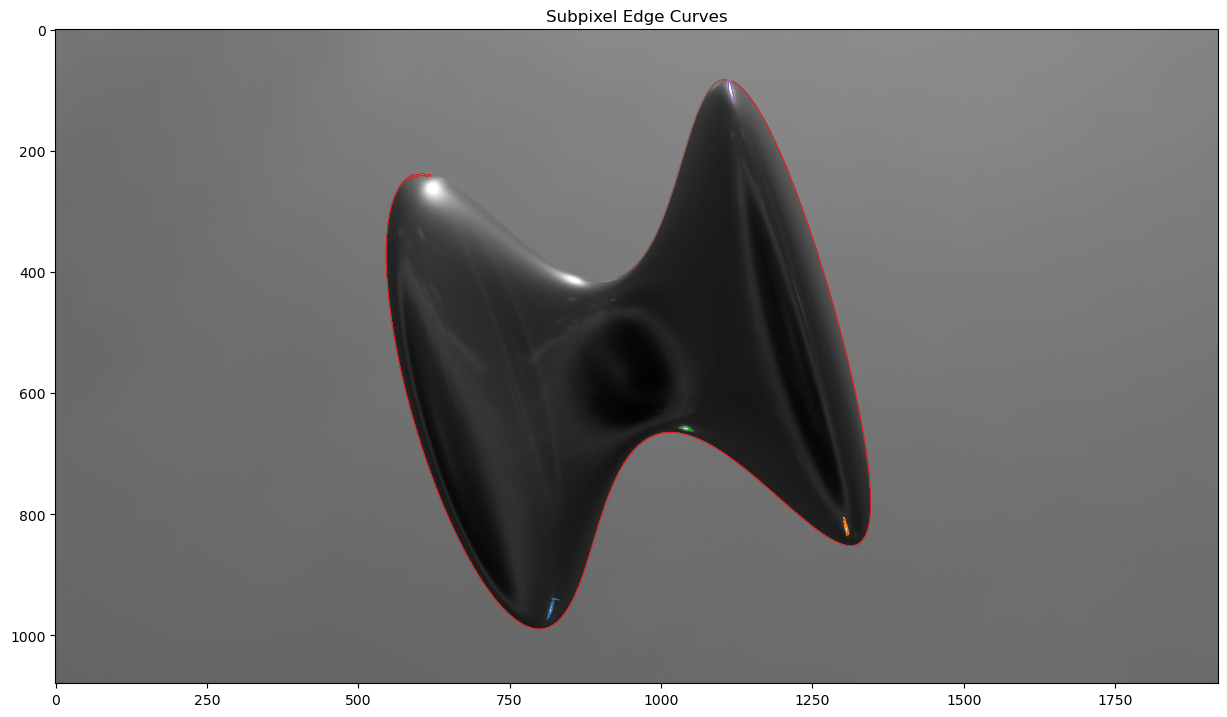

In [82]:
import cv2
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# Load image and detect edges
img = cv2.imread('../data/sky/renders/parabola11.png', cv2.IMREAD_GRAYSCALE)
# img = cv2.equalizeHist(img)
edges = cv2.Canny(img, 0, 200)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

all_subpixel_edges = []

for cnt in contours:
    if len(cnt) < 5:
        continue  # Need enough points for spline fitting

    # Extract x and y coordinates
    cnt = cnt.squeeze()  # Remove single-dim (N,1,2) -> (N,2)
    x, y = cnt[:, 0], cnt[:, 1]

    # Fit a spline to the contour
    try:
        tck, u = splprep([x, y], s=1.0)  # s controls smoothing
        u_fine = np.linspace(0, 1, len(x)*5)  # More points = higher "resolution"
        x_fine, y_fine = splev(u_fine, tck)

        subpixel_points = np.vstack((x_fine, y_fine)).T
        all_subpixel_edges.append(subpixel_points)

    except Exception as e:
        print(f"Skipping a contour due to error: {e}")
        continue

# Example: visualize result
plt.figure(figsize=(15,15))
plt.imshow(img, cmap='gray')
for subpts in all_subpixel_edges:
    plt.plot(subpts[:, 0], subpts[:, 1], linewidth=0.5)
plt.title("Subpixel Edge Curves")
plt.show()


In [75]:
len(all_subpixel_edges[0])

9710

In [73]:
len(np.argwhere(edges>0))

2519

In [60]:
len(contours[1])

2165